In [ ]:
# Project 6: U-Net and Autoencoders

# Imports
import torch
from torchvision.datasets import MNIST
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn as nn
from torchsummary import summary
from torch.optim import Adam
import numpy as np
import matplotlib.pyplot as plt
import time

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

# Global noise values
MILD = .1
MEDIUM = .25
SEVERE = .4


In [ ]:
# Load MNIST data
mnist_train = MNIST('~/data', train=True, download=True)
mnist_test = MNIST('~/data', train=False, download=True)


class MNISTDataset(Dataset):
    """Noisy wrapper for MNIST Dataset

    We can dynamically set the noise using the mu attribute
    X's are noisy images, and Y's are the clean original images
    Images are (1, 28, 28)
    """

    def __init__(self, x, y, mu):

        # Reformat input image
        x = x.view(-1, 1, 28, 28)
        normal_image = x.float()/255

        # Add the noise to the image, but keep vals in [0, 1]
        noise = torch.randn_like(normal_image, dtype=torch.float)
        noisy_image = (1 - mu) * normal_image + (mu) * noise
        noisy_image = torch.clamp(noisy_image, 0, 1)

        # Save as input and ground-truth
        self.x, self.y = noisy_image, normal_image

    def __getitem__(self, ix):
        return self.x[ix].to(device), self.y[ix].to(device)

    def get_group(self, size):
        """Get subset with `size` images"""
        return self.x[0:size].to(device), self.y[0:size].to(device)

    def __len__(self):
        return len(self.x)


In [ ]:
class UNet(nn.Module):

    """
        Our UNet is a neural network that reduces an images to core features
        (while reducing the size of the image and increasing the channels),
        and then increases it back to its original size.

        Since the input images from MNIST are size 28x28, we did not want to
        fully replicate the original UNet. Because we are simplifying the problem,
        a reduction in channel dimension makes sense here, as well as a reduction
        in total layers.

        We decided our architecture would look like this:
          - 1 CL (Convolutional Layer) followed by a Max Pool Layer 2 times, then
          - A bottom CL followed by a TCL (Transpose CL) 2 times, followed by
          - Two CL (the last one reducing the dimension size back to 1)

        The image gets reduced from a size of 28x28 -> 14x14 -> 7x7, the channel
        size gets increased from 1 -> 20 -> 40 -> 80, and then the size scales
        back up and the channel size scales back down.

        One key aspect of the UNet is that before the MaxPool layers, a copy of
        the outputs get saved so it can be concatenated later in the re-scaling side.
    """

    def __init__(self, channels=1, output_classes=10):
        super().__init__()
        self.loss_func = nn.MSELoss()

        # Convolution Layers
        self.ConvLayer1 = self.ConvLayer(1, 20, 3)
        self.MaxPool = nn.MaxPool2d(2)
        self.ConvLayer2 = self.ConvLayer(20, 40, 3)

        # Bottom Layer
        self.ConvLayer3 = self.ConvLayer(40, 80, 3)

        # Transpose Convolution Layers
        self.TransposeLayer1 = self.TransposeConvLayer(80, 40, 2)
        self.ConvLayer4 = self.ConvLayer(80, 40, 3) # Concatenate ConvLayer2 result
        self.TransposeLayer2 = self.TransposeConvLayer(40, 20, 2)
        self.ConvLayer5 = self.ConvLayer(40, 20, 3) # Concatenate ConvLayer1 result

        # Flatten to final image
        self.ConvOneByOne = nn.Conv2d(20, 1, kernel_size=1)

    def ConvLayer(self, in_ch, out_ch, kernel_size=3):
        sequence = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size, 1, 1),
            nn.ReLU())
        return sequence

    def TransposeConvLayer(self, in_ch, out_ch, kernel_size=2):
        sequence = nn.Sequential(
            nn.ConvTranspose2d(in_ch, out_ch, kernel_size, 2),
            nn.ReLU())
        return sequence

    def forward(self, x):
        a = self.ConvLayer1(x)
        x = a
        b = self.ConvLayer2(self.MaxPool(x))
        x = b
        x = self.TransposeLayer1(self.ConvLayer3(self.MaxPool(x)))
        x = self.TransposeLayer2(self.ConvLayer4(torch.cat([b,x], dim=1)))
        return self.ConvOneByOne(self.ConvLayer5(torch.cat([a,x], dim=1)))

    def num_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)


# Create a UNet instance and visualize parameter grid
unet = UNet().to(device)
print(f"Total parameters for UNet: {unet.num_parameters()}")
summary(unet, (1, 28, 28))

Total parameters for UNet: 88461
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 20, 28, 28]             200
              ReLU-2           [-1, 20, 28, 28]               0
         MaxPool2d-3           [-1, 20, 14, 14]               0
            Conv2d-4           [-1, 40, 14, 14]           7,240
              ReLU-5           [-1, 40, 14, 14]               0
         MaxPool2d-6             [-1, 40, 7, 7]               0
            Conv2d-7             [-1, 80, 7, 7]          28,880
              ReLU-8             [-1, 80, 7, 7]               0
   ConvTranspose2d-9           [-1, 40, 14, 14]          12,840
             ReLU-10           [-1, 40, 14, 14]               0
           Conv2d-11           [-1, 40, 14, 14]          28,840
             ReLU-12           [-1, 40, 14, 14]               0
  ConvTranspose2d-13           [-1, 20, 28, 28]           3,220
      

In [ ]:
class Autoencoder(nn.Module):

    """
        Our Autoencoder network is essentially the same thing as our UNet.
        However, we do not employ skip connections (we don't save the output
        of the Convolutional Layers in order to do concatenations later).

        The autoencoder employs the same architecture and size reduction/
        scaling sizes as our previous UNet architecture.
    """

    def __init__(self, channels=1, output_classes=10):
        super().__init__()
        self.loss_func = nn.MSELoss()

        self.layers = nn.Sequential(self.ConvLayer(1, 20, 3),
                                    nn.MaxPool2d(2),
                                    self.ConvLayer(20, 40, 3),
                                    nn.MaxPool2d(2),
                                    self.ConvLayer(40, 80, 3),
                                    self.TransposeConvLayer(80, 40, 2),
                                    self.TransposeConvLayer(40, 20, 2),
                                    nn.Conv2d(20, 1, kernel_size=1))

    def ConvLayer(self, in_ch, out_ch, kernel_size=3):
        return nn.Sequential(nn.Conv2d(in_ch, out_ch, kernel_size, 1, 1),
                             nn.ReLU())

    def TransposeConvLayer(self, in_ch, out_ch, kernel_size=2):
        return nn.Sequential(nn.ConvTranspose2d(in_ch, in_ch, kernel_size, 2),
                             nn.ReLU(),
                             nn.Conv2d(in_ch, out_ch, 3, 1, 1),
                             nn.ReLU())

    def forward(self, x):
        return self.layers(x)

    def num_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)


# Create an autoencoder instance and visualize parameter grid
autoencoder = Autoencoder().to(device)
print(f"Total parameters for Autoencoder: {autoencoder.num_parameters()}")
summary(autoencoder, (1, 28, 28))

Total parameters for Autoencoder: 104521
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 20, 28, 28]             200
              ReLU-2           [-1, 20, 28, 28]               0
         MaxPool2d-3           [-1, 20, 14, 14]               0
            Conv2d-4           [-1, 40, 14, 14]           7,240
              ReLU-5           [-1, 40, 14, 14]               0
         MaxPool2d-6             [-1, 40, 7, 7]               0
            Conv2d-7             [-1, 80, 7, 7]          28,880
              ReLU-8             [-1, 80, 7, 7]               0
   ConvTranspose2d-9           [-1, 80, 14, 14]          25,680
             ReLU-10           [-1, 80, 14, 14]               0
           Conv2d-11           [-1, 40, 14, 14]          28,840
             ReLU-12           [-1, 40, 14, 14]               0
  ConvTranspose2d-13           [-1, 40, 28, 28]           6,44

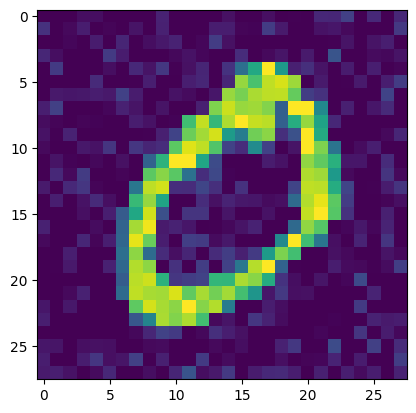

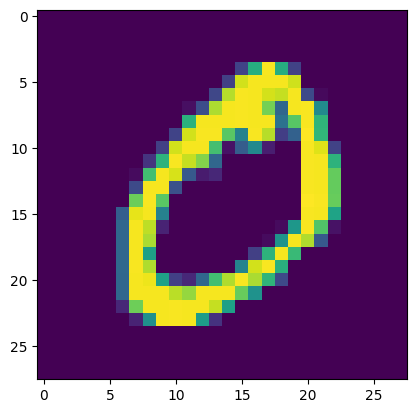

Running Epoch 1 of 5
Running Epoch 2 of 5
Running Epoch 3 of 5
Running Epoch 4 of 5
Running Epoch 5 of 5
Running Epoch 1 of 5
Running Epoch 2 of 5
Running Epoch 3 of 5
Running Epoch 4 of 5
Running Epoch 5 of 5


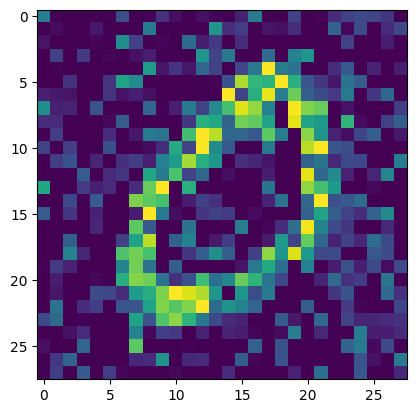

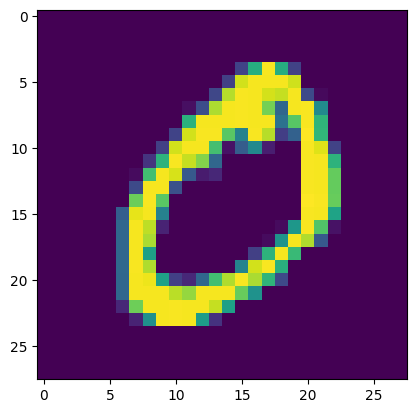

Running Epoch 1 of 5
Running Epoch 2 of 5
Running Epoch 3 of 5
Running Epoch 4 of 5
Running Epoch 5 of 5
Running Epoch 1 of 5
Running Epoch 2 of 5
Running Epoch 3 of 5
Running Epoch 4 of 5
Running Epoch 5 of 5


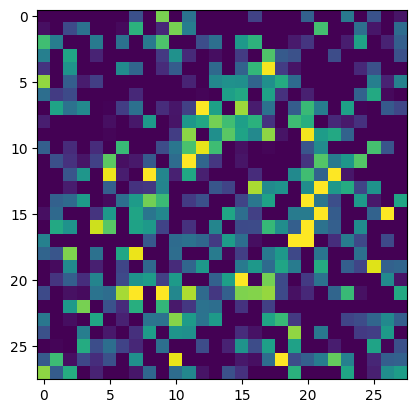

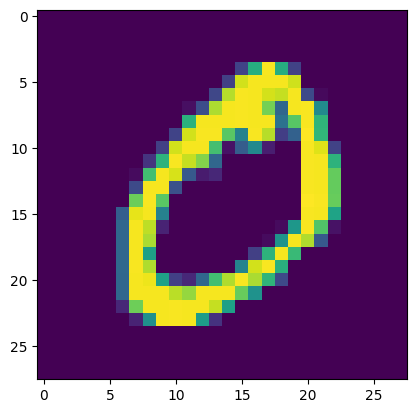

Running Epoch 1 of 5
Running Epoch 2 of 5
Running Epoch 3 of 5
Running Epoch 4 of 5
Running Epoch 5 of 5
Running Epoch 1 of 5
Running Epoch 2 of 5
Running Epoch 3 of 5
Running Epoch 4 of 5
Running Epoch 5 of 5


In [ ]:
def train_batch(model, X_train, Y_train, opt):
    opt.zero_grad()                              # Flush memory
    pred = model(X_train)                        # Get predictions
    batch_loss = model.loss_func(pred, Y_train)  # Compute loss
    batch_loss.backward()                        # Compute gradients
    opt.step()                                   # Make a GD step
    return batch_loss.detach().cpu().numpy()


def train(model, train_dl, epochs, optimizer):

    loss_history = []
    start = time.time()
    for epoch in range(epochs):

        print(f"Running Epoch {epoch + 1} of {epochs}")
        epoch_losses = []
        for i, batch in enumerate(train_dl):
            x, y = batch
            x, y = x.to(device), y.to(device)
            batch_loss = train_batch(model, x, y, optimizer)
            epoch_losses.append(batch_loss)

        epoch_loss = np.mean(epoch_losses)
        loss_history.append(epoch_loss)

    end = time.time()
    training_time = end - start
    return loss_history, training_time


# Train the models
unet_models = []
unet_losses = []
unet_times = []
autoencoder_models = []
autoencoder_losses = []
autoencoder_times = []
noise_levels = [MILD, MEDIUM, SEVERE]
for noise in noise_levels:

    # Create dataset and loader for training and testing
    train_dataset = MNISTDataset(mnist_train.data, mnist_train.targets, noise)
    train_dl = DataLoader(train_dataset,batch_size=128, shuffle=True)

    # Plot a sample of the noisiness
    normal, noisy = train_dataset[1]
    plt.imshow(normal.cpu()[0, :, :])
    plt.show()
    plt.imshow(noisy.cpu()[0, :, :])
    plt.show()

    # Create Models
    unet = UNet().to(device)
    autoencoder = Autoencoder().to(device)

    # Train competing models
    num_epochs = 5
    lr = .001
    u_opt = Adam(unet.parameters(), lr=lr)
    a_opt = Adam(autoencoder.parameters(), lr=lr)
    u_loss_history, u_train_time = train(unet, train_dl, num_epochs, u_opt)
    a_loss_history, a_train_time = train(autoencoder, train_dl, num_epochs, a_opt)

    # Save Models
    unet_models.append(unet)
    unet_losses.append(u_loss_history)
    unet_times.append(u_train_time)
    autoencoder_models.append(autoencoder)
    autoencoder_losses.append(a_loss_history)
    autoencoder_times.append(a_train_time)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.4/65.4 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 6.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.7/203.7 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 21.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 39.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.9/98.9 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 55.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.6/30.6 MB 20.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.4/169.4 kB 19.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 73.6 MB/s eta 0:0

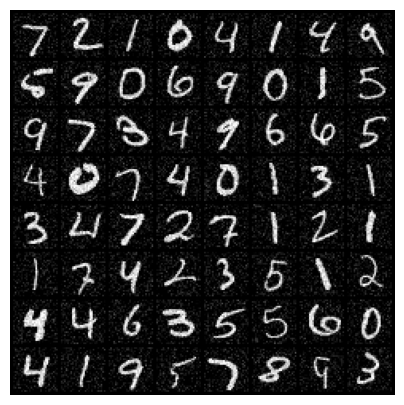

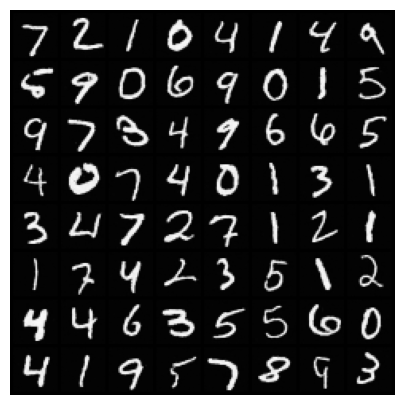

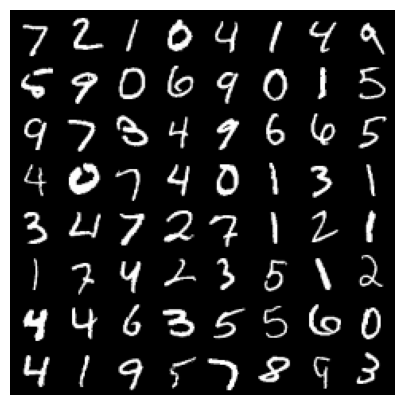

-- Starting Autoencoder tests - Noise: 0.1
Trainint time: 33.71963810920715
MSE: 0.0023206414189189672
Inference time: 0.010048151016235352


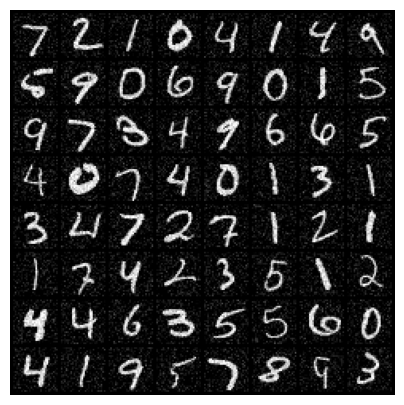

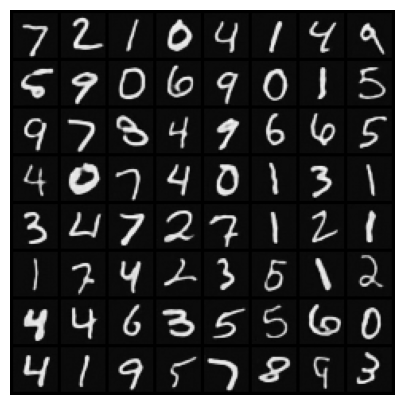

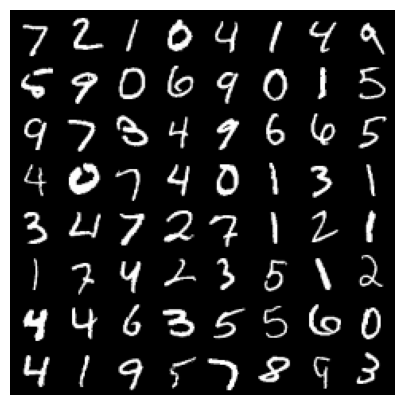

-- Starting U-Net tests - Noise: 0.25
Training time: 32.061827421188354
MSE: 0.00507561769336462
Inference time: 0.0016396045684814453


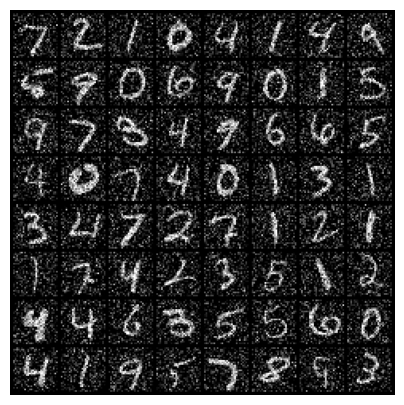

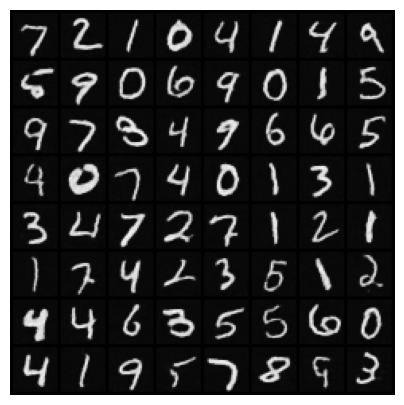

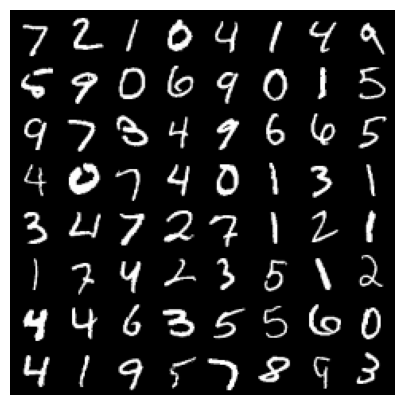

-- Starting Autoencoder tests - Noise: 0.25
Trainint time: 32.568703174591064
MSE: 0.005902855657041073
Inference time: 0.001626729965209961


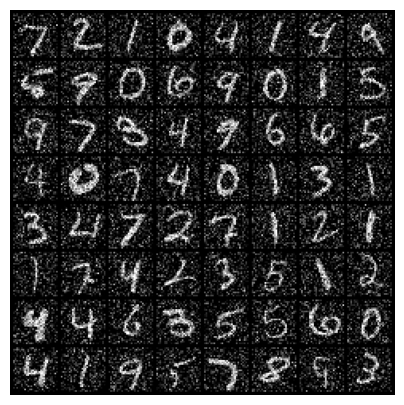

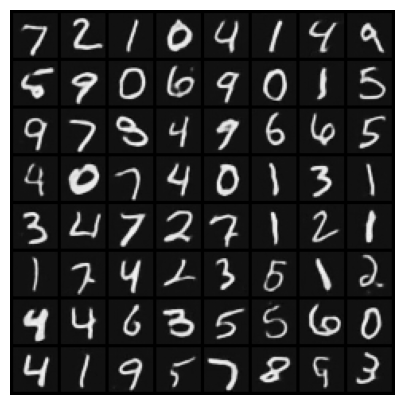

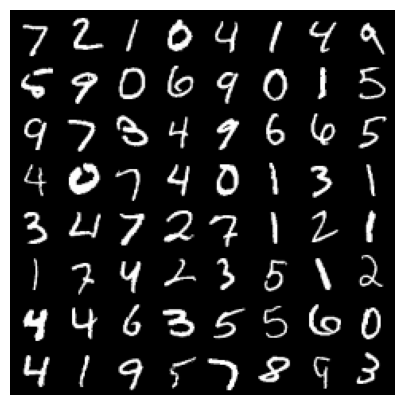

-- Starting U-Net tests - Noise: 0.4
Training time: 31.625856161117554
MSE: 0.014735919423401356
Inference time: 0.0017213821411132812


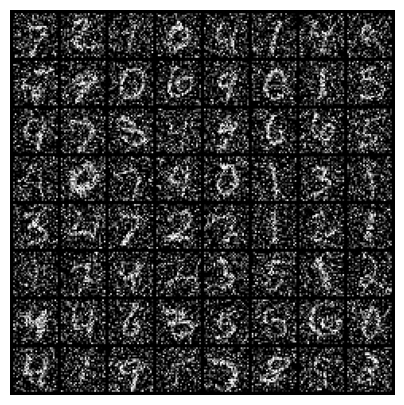

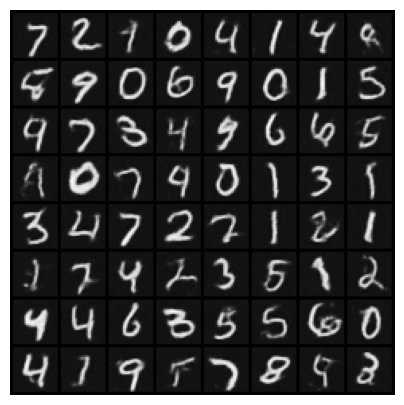

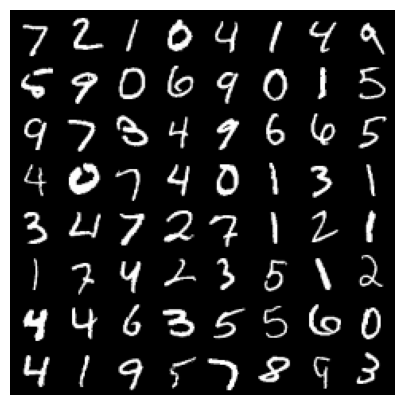

-- Starting Autoencoder tests - Noise: 0.4
Trainint time: 33.11465501785278
MSE: 0.015850208699703217
Inference time: 0.0014944076538085938


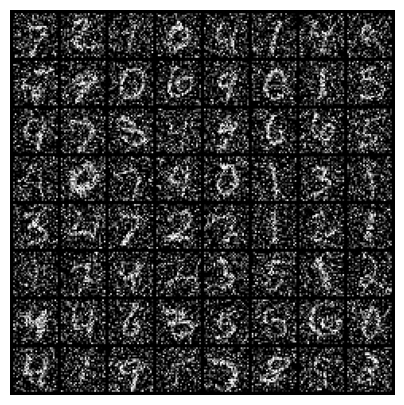

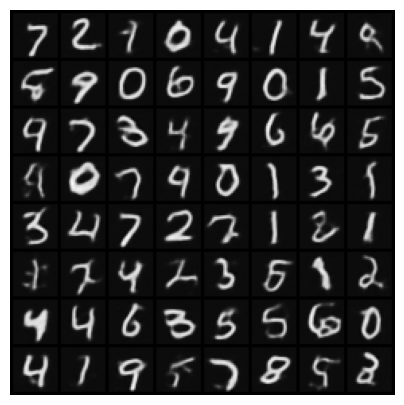

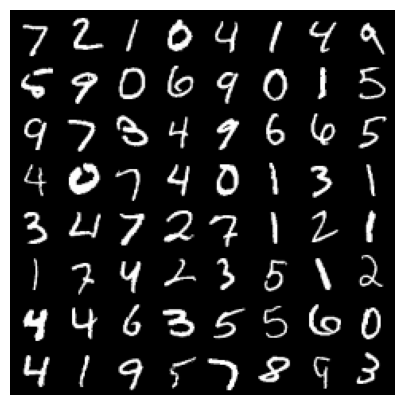

In [ ]:
# Test the models
!pip install -q torch_snippets

from torchvision.utils import make_grid
from torch_snippets import show


def plot_loss(loss_history):
    plt.plot(loss_history)
    plt.title("Loss Over Time")
    plt.xlabel("Epochs")
    plt.ylabel("Loss Value")
    plt.show()


def plot_comparison(model, x, y):

    # Plot noisy input
    true_images = x
    true_grid = make_grid(true_images, nrow=8, normalize=True)
    show(true_grid.cpu().detach().permute(1,2,0), sz=5)

    # Plot a grid of our predictions
    predicted_images = model(x).data.cpu().view(64, 1, 28, 28)
    prediction_grid = make_grid(predicted_images, nrow=8, normalize=True)
    show(prediction_grid.cpu().detach().permute(1,2,0), sz=5)

    # Plot a grid of real images
    true_images = y
    true_grid = make_grid(true_images, nrow=8, normalize=True)
    show(true_grid.cpu().detach().permute(1,2,0), sz=5)


def calculate_mse(model, x, y):

    # Calculate MSE per pixel across all images pairwise
    loss = nn.MSELoss()
    start = time.time()
    pred = model(x)
    end = time.time()
    output = loss(pred, y)

    return output, end - start


def run_tests(model, dataset):

    # Calculate quantitative stats
    x, y =dataset.get_group(len(dataset))
    mse, test_time = calculate_mse(model, x, y)
    print(f"MSE: {mse}")
    print(f"Inference time: {test_time}")

    # Plot for qualitative differences
    x, y = dataset.get_group(64)
    plot_comparison(model, x, y)


# Run through our tests on the saved models
for i, noise in enumerate(noise_levels):

    test_dataset = MNISTDataset(mnist_test.data, mnist_test.targets, noise)

    print(f"-- Starting U-Net tests - Noise: {noise}")
    print(f"Training time: {unet_times[i]}")
    run_tests(unet_models[i], test_dataset)
    print(f"-- Starting Autoencoder tests - Noise: {noise}")
    print(f"Trainint time: {autoencoder_times[i]}")
    run_tests(autoencoder_models[i], test_dataset)

